In [ ]:
import numpy as np
from collections import defaultdict
from itertools import combinations, permutations
from bisect import bisect_left
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
a = np.array([18.85,16.93,19.29,18.31,17.27,18.64,17.82,19.00,19.58,18.04,17.27,19.19])
b = np.array([19.23,19.57,19.50,18.64,18.70,19.54,19.04,20.67,20.71,18.99,19.37,19.06])

## Two-Sample Permutation Test

The two-sample t-test gives `[-1.7348128 -0.4035205]` as a 95% confidence interval for the true difference in means between `a` and `b`. Following this result, we test various $\Delta_0 \in [-2, 0]$. For each $\Delta_0$, we collect all possible two-sample permutations. For each permutation, we compute the test statistic $t = |\bar X_1 - \bar X_2 - \Delta_0|$. The p-value associated with each $\Delta_0$ is the proportion of permutations such that $t \ge t_{obs}$, where $t_{obs}$ is the test statistic computed for the observed data $X_1 =$ `a` and $X_2 =$ `b`.

The goal is to compute a confidence interval for the plausible (i.e., $\alpha = 0.05$) values of the true difference in means $\delta$. We note that the $(\Delta_0, p)$ plot appears to be strictly decreasing. I.e., as $\Delta_0 \in [-2,0]$ increases, $p$ decreases.

In [6]:
def pval(a, b, delta0=0):
    a_shifted = a - delta0
    t_obs = np.mean(a_shifted) - np.mean(b)  # test statistic for observed
    data = np.concatenate((a_shifted,b))
    TOTAL = np.sum(data)
    n1, n2 = len(a), len(b)
    
    n_combos = 0
    #count = 0                               # num. permutations with t >= t_obs
    combos = combinations(range(n1+n2), n1)  # all possible ways to choose n1 from n1 + n2
    count_left = count_right = 0

    for combo in combos:
        group1 = [data[x] for x in combo]
        x1bar = np.mean(group1)
        x2bar = (TOTAL - (n1 * x1bar)) / n2
        t = x1bar - x2bar
        count_left += (t <= -abs(t_obs))
        count_right += (t >= abs(t_obs))
        n_combos += 1
        
    #p = (count_left + count_right)/n_combos  # proportion w/ "as or more extreme" test statistic
    p_values = np.array([(count_left + count_right), count_left, count_right])
    p_values = p_values / n_combos
    return delta0, p_values

In [20]:
def percent_change(old, new):
    return 100 * abs(new - old) / old

In [31]:
"""
Parameters:
x1 - data for group 1
x2 - data for group 2
start, end - initial bounds

This function performs a binary search on the interval [start, end]
corresponding to the (delta0, p_value) distribution.

Note that we assume the distribution is monotone DECREASING on [start, end].
I.e., the p-value associated with delta0 = start is larger than that for delta0 = end.

Due to convergence concerns, this function terminates when either:
(1) We have an approximation for delta0 such that the corresponding p-value is within
    a desired margin of alpha.
(2) The p-value from one iteration to the next has a percent change less than the desired
    threshold.
"""

def search(x1, x2, start, end, margin=0.0001, alpha=0.05, threshold=1):
    p = 0
    i = 0

    while (not i) or (abs(p - alpha) > margin):  # criterion (1)
        print("iteration", i)

        mid = (start + end) / 2
        print("delta0 =", mid, " in [", start, ",", end, "]")

        delta0, p_values = pval(x1, x2, delta0=mid)
        p_new = p_values[0]
        if p_new > alpha + margin:
            start = mid
        elif p_new < alpha - margin:
            end = mid
        
        # criterion (2)
        if p and percent_change(p, p_new) <= threshold:
            break

        p = p_new
        print("p =", p)
        print("---")
        
        i += 1
        
    return delta0, p

## Approximating the Confidence Interval

We use `search()` to find an upper bound for the 95% confidence interval. To get a general idea of $(\Delta_0, p)$ distribution looks like, we will compute $p$ for discrete evenly spaced $\Delta_0 \in [-3,1]$, a more conservative interval based on the earlier t-test.

In [ ]:
res = []

# compute p for each delta0
for d in np.linspace(-3, 1, num=401):
    print("---")
    delta, p_values = pval(a, b, delta0=d)
    print("delta0 =", delta)
    print("p =", p_values[0])
    res.append((delta, p_values[0]))
    
res

Below is the plot of the 401 evenly spaced $\Delta_0 \in [-3, 1]$. We will use this plot to determine approximations for the 95% confidence interval. For the lower and upper bounds of this approximation, we select the two points which are sufficiently close to the line $p = 0.05$.

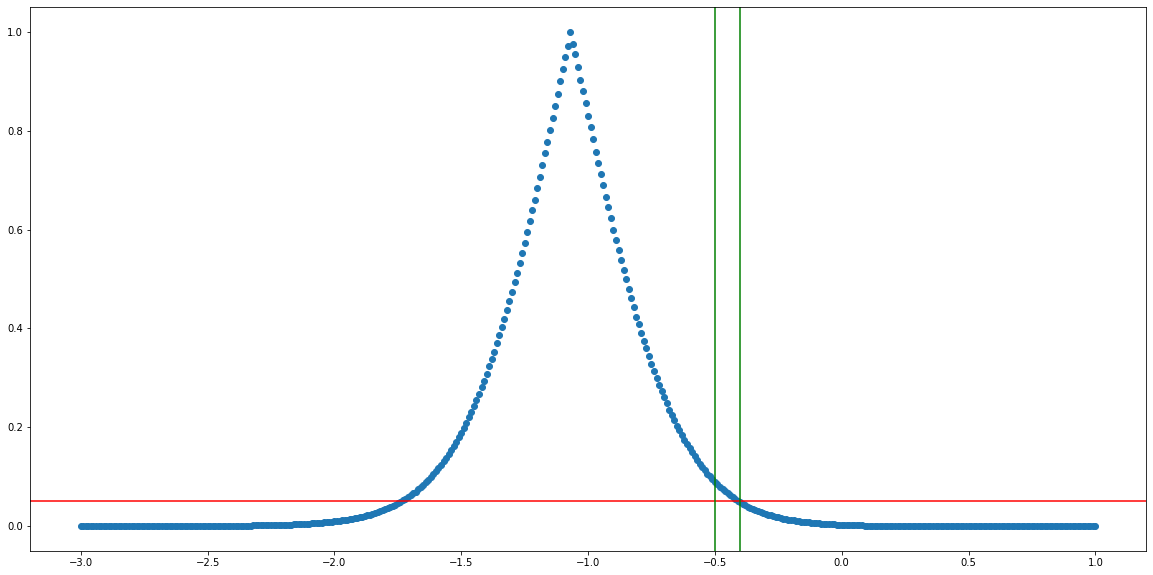

In [57]:
data = np.array(res)
x, y = data.T
plt.scatter(x,y)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.axvline(x=-0.5, color='g', linestyle='-')
plt.axvline(x=-0.4, color='g', linestyle='-')
plt.show()

We can see that, assuming monotonicity, the upper bound of the confidence interval is between -0.5 and -0.4. We verify that $p$ for $\Delta_0 = -0.5$ is greater than $p$ for $\Delta_0 = -0.4$.

In [12]:
pval(a, b, -0.5)

(-0.5, array([0.08907918, 0.04475888, 0.0443203 ]))

In [43]:
pval(a, b, -0.4)

(-0.4, [0.04812481232591611, 0.024178338823647748, 0.02394647350226836])

We now look for a good approximation for $\Delta$ in the interval $[-0.5, -0.4]$, bisecting the remaining candidate set each time until we find a sufficiently narrow interval that satisfies the earlier criteria.

In [17]:
search(a, b, -0.5, -0.4)

iteration 0
delta0 = -0.45  in [ -0.45 , -0.4 ]
p = 0.0662983200673334
---
iteration 1
delta0 = -0.42500000000000004  in [ -0.42500000000000004 , -0.4 ]
p = 0.056626540776493664
---
iteration 2
delta0 = -0.41250000000000003  in [ -0.41250000000000003 , -0.4 ]
p = 0.05226658521179991
---
iteration 3
delta0 = -0.40625  in [ -0.40625 , -0.4 ]
p = 0.05016352606876231
---
iteration 4
delta0 = -0.403125  in [ -0.40625 , -0.403125 ]
p = 0.0491214264265819
---
iteration 5
delta0 = -0.4046875  in [ -0.40625 , -0.4046875 ]
p = 0.049602167922264837
---
iteration 6
delta0 = -0.40546875  in [ -0.40625 , -0.4046875 ]
p = 0.04990910287720087
---


(-0.40546875, 0.04990910287720087)

After running for 7 iterations, we have an approximation $\hat\delta_0 = -0.40546875$ which returns a p-value within our specified margin of error of $\alpha$.

To verify that condition (2) works, let us set the threshold such that the search terminates after the iteration 1. From above, we see that iterations 0 and 1 return p-values of `0.0662983200673334` and `0.056626540776493664` respectively. This is a percent change of <15%, so if we set the threshold to 15, then the search should stop after iteration 1.

In [27]:
percent_change(0.0662983200673334, 0.056626540776493664)

14.588272042213067

In [32]:
search(a, b, -0.5, -0.4, threshold=15)

iteration 0
delta0 = -0.45  in [ -0.5 , -0.4 ]
p = 0.0662983200673334
---
iteration 1
delta0 = -0.42500000000000004  in [ -0.45 , -0.4 ]


(-0.42500000000000004, 0.0662983200673334)